<a href="https://colab.research.google.com/github/mujahidrj/Artificial-Intelligence/blob/master/HW4/HW4_Question_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3 Part 2

You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

# Fine-tuning Xception 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 02:34:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   170MB/s    in 0.4s    

2020-04-22 02:34:45 (170 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [44]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

# Shows all the available layers
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# Changed the following layer
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 47,076,905
Trainable params: 26,215,425
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [48]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

# Higher learning rate than what is used later on
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 21s 212ms/step - loss: 0.4895 - acc: 0.7525 - val_loss: 0.4295 - val_acc: 0.9550
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 0.3395 - acc: 0.8395 - val_loss: 0.0015 - val_acc: 0.9610
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 0.3493 - acc: 0.8415 - val_loss: 0.0135 - val_acc: 0.9610
Epoch 4/100
100/100 [==============================] - 18s 183ms/step - loss: 0.3524 - acc: 0.8460 - val_loss: 0.1767 - val_acc: 0.9700
Epoch 5/100
100/100 [==============================] - 18s 182ms/step - loss: 0.3175 - acc: 0.8525 - val_loss: 1.0908e-04 - val_acc: 0.9610
Epoch 6/100
100/100 [==============================] - 18s 183ms/step - loss: 0.3184 - acc: 0.8625 - val_loss: 0.3943 - val_acc: 0.9570
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 0.3038 - acc: 0.86

## Display curves of loss and accuracy during training

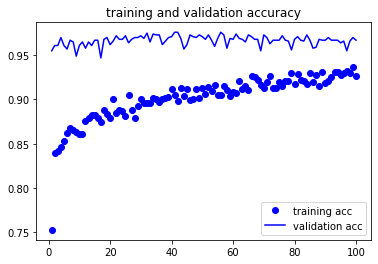

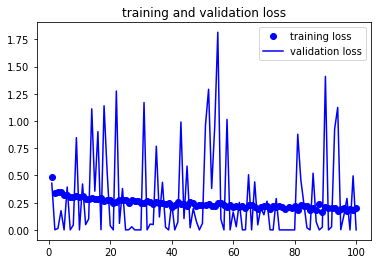

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Fine tuning results are usually done if the data set being used isn't very different than the data from the pre-trained model. One problem with fine tuning results for a small dataset can lead to overfitting.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block13_sepconv2':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [51]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

50/50 [==============================] - 11s 218ms/step - loss: 0.1292 - acc: 0.9480 - val_loss: 0.1652 - val_acc: 0.9470
Epoch 82/100
50/50 [==============================] - 11s 217ms/step - loss: 0.1478 - acc: 0.9460 - val_loss: 0.0071 - val_acc: 0.9400
Epoch 83/100
50/50 [==============================] - 11s 217ms/step - loss: 0.1679 - acc: 0.9400 - val_loss: 0.8106 - val_acc: 0.9490
Epoch 84/100
50/50 [==============================] - 11s 218ms/step - loss: 0.1171 - acc: 0.9530 - val_loss: 0.6899 - val_acc: 0.9300
Epoch 85/100
50/50 [==============================] - 11s 219ms/step - loss: 0.1435 - acc: 0.9410 - val_loss: 0.3637 - val_acc: 0.9550
Epoch 86/100
50/50 [==============================] - 11s 218ms/step - loss: 0.1432 - acc: 0.9390 - val_loss: 0.2872 - val_acc: 0.9320
Epoch 87/100
50/50 [==============================] - 11s 216ms/step - loss: 0.1325 - acc: 0.9380 - val_loss: 0.8083 - val_acc: 0.9370
Epoch 88/100
50/50 [==============================] - 11s 217ms/step

## Display learning curves during fine-tuning

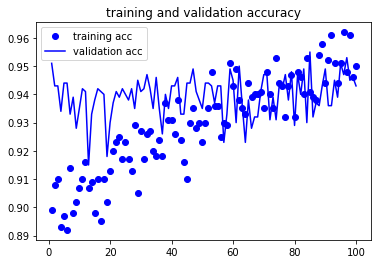

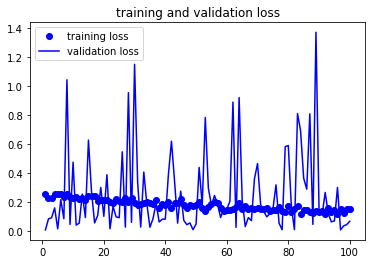

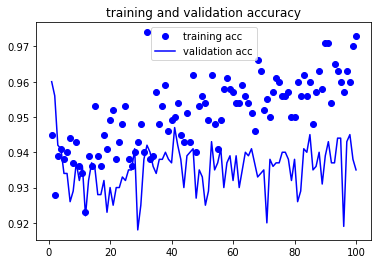

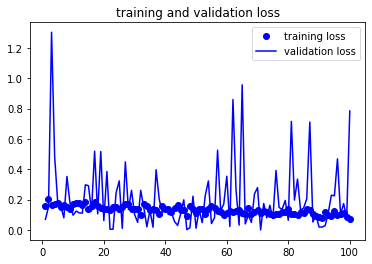

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#Print out validation loss and accuracy

In [53]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.028924351558089256
Validation accuracy: 0.9430000185966492
Validation loss: 0.7836729288101196
Validation accuracy: 0.9350000023841858


# Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

To download the model, uncomment the code below

In [0]:
# from google.colab import files

# with open(model_fname, 'r') as f:
#   files.download(model_fname)